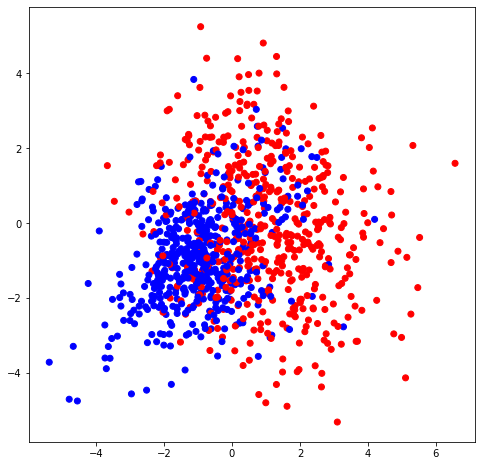

[1, 1, 1] [1, 0, 0] [1, 0, 1] [0, 0, 1]
[(1, 1, 1, 0), (1, 0, 0, 0), (1, 0, 1, 1)]
Точность случайного леса из 1 деревьев на обучающей выборке: 93.429
Точность случайного леса из 1 деревьев на тестовой выборке: 81.000
Точность случайного леса из 3 деревьев на обучающей выборке: 97.857
Точность случайного леса из 3 деревьев на тестовой выборке: 84.667
Точность случайного леса из 10 деревьев на обучающей выборке: 98.857
Точность случайного леса из 10 деревьев на тестовой выборке: 86.333
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 88.000


In [1]:
# импортировать всё из урока 5 (вместо того чтобы копировать по частям)
# и заменить отдельные функции на свои согласно заданию
%run ./Lesson_5_210622.ipynb

1. Задание:  
    - Сформировать с помощью `sklearn.make_classification` датасет из 1000 объектов с **двумя** признаками.  
    - Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).  
    - Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции `predict` на `tree_vote`).   
    - Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=2, flip_y=0.1, random_state=1)

In [3]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(X, 
                                                                    y, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [8]:
my_forest = {}
train_accuracy = {}
test_accuracy = {}
for n_trees in (1, 3, 10, 50, 100, 200):
    my_forest[n_trees] = random_forest(train_data, train_labels, n_trees)
    train_answers = tree_vote(my_forest[n_trees], train_data)
    test_answers = tree_vote(my_forest[n_trees], test_data)
    train_accuracy[n_trees] = accuracy_metric(train_labels, train_answers)
    test_accuracy[n_trees] = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса\tиз {n_trees} деревьев\tна обучающей выборке: {train_accuracy[n_trees]:.3f}'
          f'\tна тестовой выборке: {test_accuracy[n_trees]:.3f}')

Точность случайного леса из 1 деревьев	на обучающей выборке: 93.714	на тестовой выборке: 77.333
Точность случайного леса из 3 деревьев	на обучающей выборке: 96.143	на тестовой выборке: 77.667
Точность случайного леса из 10 деревьев	на обучающей выборке: 98.429	на тестовой выборке: 80.000
Точность случайного леса из 50 деревьев	на обучающей выборке: 99.857	на тестовой выборке: 79.333
Точность случайного леса из 100 деревьев	на обучающей выборке: 100.000	на тестовой выборке: 79.667
Точность случайного леса из 200 деревьев	на обучающей выборке: 100.000	на тестовой выборке: 78.333


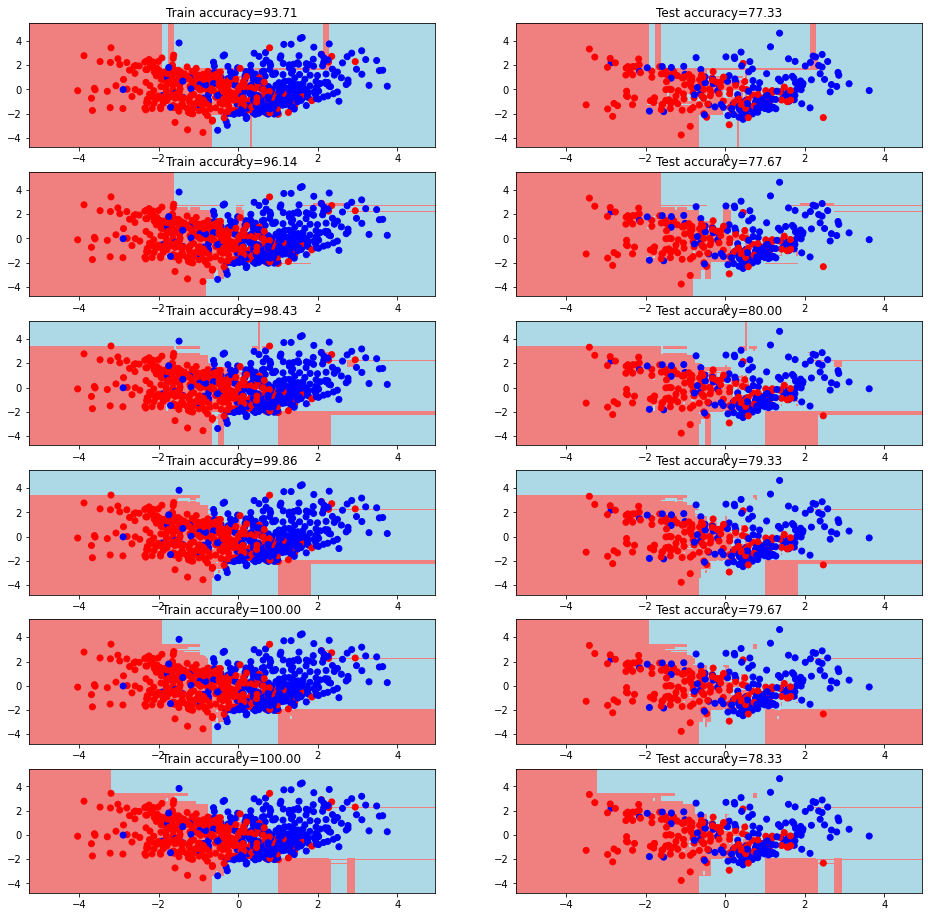

In [9]:
def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

xx, yy = get_meshgrid(train_data)
plt.figure(figsize=(16,16))
k = 1
for n_trees in (1, 3, 10, 50, 100, 200):
    mesh_predictions = np.array(tree_vote(my_forest[n_trees], np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    
    plt.subplot(6,2,k)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy[n_trees]:.2f}')
    k += 1

    plt.subplot(6,2,k)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy[n_trees]:.2f}')
    k += 1

2. (\*) Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [ ]:
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    out_of_bag = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        extra = set(enumerate(n_samples))
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            
            extra.pop(sample_index)
            
        bootstrap.append((b_data, b_labels))
        
        out_of_bag.append(([b_data[k] for k in extra], [b_labels[k] for k in extra]))
        
    return bootstrap, out_of_bag

In [ ]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap, out_of_bag = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest, (bootstrap, out_of_bag)

In [ ]:
def calc_logloss(y, p):
    """логистическая функция потерь"""
    eps = 1e-15
    p_ = np.clip(p, eps, 1.0 - eps)
    err = np.mean(- y * np.log(p_) - (1.0 - y) * np.log(1.0 - p_))
    return err

In [ ]:
def oob():
    return sum(calc_logloss(y, x))